### Imports

In [1]:
import torch
import rasterio
import numpy as np
import cv2

### Preprocessing

In [26]:
def preProcess1(img):
    img = np.clip(img, -20, 5)
    img = 10 ** (img / 20.0)
    return np.clip(img, 0, 255)

def preProcess2(img):
    log_transformed_values = np.log(img)
    percentiles = np.percentile(log_transformed_values, q=[0, 25, 50, 75, 100])
    remapped_values = 1 / (1 + np.exp(-(log_transformed_values - percentiles[1])))
    return torch.from_numpy(remapped_values)

### Spatial augmentation

In [24]:
# TODO: give limits to random
def spatialAug1(sentinel1):
    vv = torch.tensor(sentinel1[0])
    vh = torch.tensor(sentinel1[1])

    i1 = np.random.randint(low=0, high=vv.shape[0]-2, size=None)
    i2 = np.random.randint(low=i1, high=vv.shape[0]-1, size=None)
    j1 = np.random.randint(low=0, high=vv.shape[1]-2, size=None)
    j2 = np.random.randint(low=j1, high=vv.shape[1]-1, size=None)

    vv_croped = vv[i1:i2, j1:j2]
    vh_croped = vh[i1:i2, j1:j2]

    vv_resized = cv2.resize(vv_croped.numpy(), dsize=(512, 512))
    vh_resized = cv2.resize(vh_croped.numpy(), dsize=(512, 512))
    fill = np.zeros((512,512))

    return torch.from_numpy(np.stack((vv_resized, vh_resized, fill), axis=0))

def spatialAug2(sentinel2):
    r = torch.tensor(sentinel2[0])
    g = torch.tensor(sentinel2[1])
    b = torch.tensor(sentinel2[2])

    i1 = np.random.randint(low=0, high=r.shape[0]-2, size=None)
    i2 = np.random.randint(low=i1, high=r.shape[0]-1, size=None)
    j1 = np.random.randint(low=0, high=r.shape[1]-2, size=None)
    j2 = np.random.randint(low=j1, high=r.shape[1]-1, size=None)

    r_croped = r[i1:i2, j1:j2]
    g_croped = g[i1:i2, j1:j2]
    b_croped = b[i1:i2, j1:j2]

    r_resized = cv2.resize(r_croped.numpy(), dsize=(512, 512))
    g_resized = cv2.resize(g_croped.numpy(), dsize=(512, 512))
    b_resized = cv2.resize(b_croped.numpy(), dsize=(512, 512))

    return torch.from_numpy(np.stack((r_resized, g_resized, b_resized), axis=0))

### Models

In [43]:
resnet1  = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet2  = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 512)
        self.fc2 = torch.nn.Linear(512, output_dim)
        self.norm = torch.nn.LayerNorm(output_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.norm(x)
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x

Using cache found in /home/charlie/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/charlie/.cache/torch/hub/pytorch_vision_v0.10.0


### Model training

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

def criterion(x, y):
    l = torch.empty(len(x))
    for i in range(len(l)):
        lxyi = torch.exp(torch.nn.functional.cosine_similarity(x[i], y[i], dim=0))
        lyxi = torch.exp(torch.nn.functional.cosine_similarity(y[i], x[i], dim=0))

        simxy, simxx, simyx, simyy = 0,0,0,0
        for j in range(len(x)):
            simxy += torch.exp(torch.nn.functional.cosine_similarity(x[i], y[j], dim=0))
            simyx += torch.exp(torch.nn.functional.cosine_similarity(y[i], x[j], dim=0))
            if j!=i:
                simxx += torch.exp(torch.nn.functional.cosine_similarity(x[i], x[j], dim=0))
                simyy += torch.exp(torch.nn.functional.cosine_similarity(y[i], y[j], dim=0))
               

        l[i] = -torch.log(lxyi/(simxx + simxy)) + -torch.log(lyxi/(simyy + simyx))
    return torch.sum(l)

def preTrain(model, batch, weight_decay=0.0, optimizer="sgd", learning_rate=0.1, momentum=0.9, num_epochs=10):
    g1 = ProjectionHead(1000)
    g2 = ProjectionHead(1000)
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer1 = torch.optim.SGD(model[0].parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        optimizer2 = torch.optim.SGD(model[1].parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        optimizerG1 = torch.optim.SGD(g1.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        optimizerG2 = torch.optim.SGD(g2.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer1 = torch.optim.Adam(model[0].parameters(), lr=learning_rate, weight_decay=weight_decay)
        optimizer2 = torch.optim.Adam(model[1].parameters(), lr=learning_rate, weight_decay=weight_decay)
        optimizerG1 = torch.optim.Adam(g1.parameters(), lr=learning_rate, weight_decay=weight_decay)
        optimizerG2 = torch.optim.Adam(g2.parameters(), lr=learning_rate, weight_decay=weight_decay)

    iters, losses = [], []
    for epoch in range(num_epochs):
        for imgs in batch:
            imgs1 = imgs[0].to(device)
            imgs2 = imgs[1].to(device)

            model[0].float()
            model[1].float()

            model[0].train()
            model[1].train()
            g1.train()
            g2.train()

            x = model[0](imgs1.unsqueeze(0).float())
            y = model[1](imgs2.unsqueeze(0).float())
            x = g1(x)
            y = g2(y)

            loss = criterion(x, y)
            loss.backward()

            optimizer1.step()
            optimizer1.zero_grad()
            optimizer2.step()
            optimizer2.zero_grad()
            optimizerG1.step()
            optimizerG1.zero_grad()
            optimizerG2.step()
            optimizerG2.zero_grad()

            losses.append(float(loss)/len(batch))
    return losses

In [69]:
# Open the GeoTIFF image
sentinel1_image_path = "sentinel1_example.tif"
sentinel2_image_path = "sentinel2_example.tif"

sentinel1 = rasterio.open(sentinel1_image_path)
sentinel2 = rasterio.open(sentinel2_image_path)

vv = np.array(sentinel1.read(1))
vh = np.array(sentinel1.read(2))
r = np.array(sentinel2.read(3))
g = np.array(sentinel2.read(2))
b = np.array(sentinel2.read(1))

img1 = spatialAug1(preProcess1(np.stack((vv, vh))))
img2 = spatialAug2(preProcess2(np.stack((r,g,b))))

batch = []
batch.append([img1, img2])

losses = preTrain((resnet1, resnet2), batch)

/tmp/ipykernel_397/2421878645.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(sentinel2[0])
/tmp/ipykernel_397/2421878645.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g = torch.tensor(sentinel2[1])
/tmp/ipykernel_397/2421878645.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(sentinel2[2])


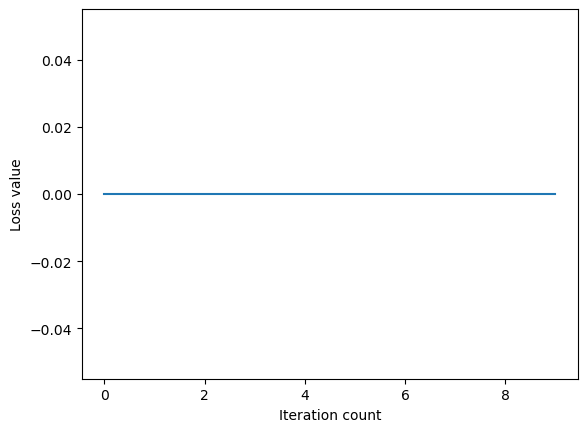

In [70]:
import matplotlib.pyplot as plt

plt.plot(range(10), losses, label='Loss evolution')
plt.xlabel("Iteration count")
plt.ylabel("Loss value")

plt.show()

### Model evaluation